ridge, lasso, xgb, lgbm stacking

In [1]:
# module import

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression , Ridge , Lasso
from sklearn.metrics import mean_squared_error
import lightgbm
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

import datetime
import glob
import os

In [2]:
from IPython.display import display

pd.options.display.precision = 7
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
pd.options.display.max_colwidth = 100

pd.set_option('display.max_columns', 100)

# Set Data

In [3]:
def set_data(train, test):
    X_train = train.drop('uv', axis=1, inplace=False)
    y_train = train['uv']
    
    X_test = test.drop('uv', axis=1, inplace=False)
    y_test = test['uv']
    
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                      test_size=0.2, random_state=42)
    return X_train, X_val, y_train, y_val, X_test, y_test

# Modeling - Stacking
## ridge, lasso, xgb, lgbm stacking (meta model - lasso)

In [4]:
def linear_reg(X_train, X_val, y_train, y_val, X_test):  
    # 개별 모델의 학습
    ridge_reg = Ridge(alpha=8)
    ridge_reg.fit(X_train, y_train)
    lasso_reg = Lasso(alpha=0.001)
    lasso_reg.fit(X_train, y_train)
    
    # 개별 모델 예측
    ridge_pred = ridge_reg.predict(X_test)
    lasso_pred = lasso_reg.predict(X_test)
    
    # 개별 모델 예측값 혼합으로 최종 예측값 도출
    lr_pred = 0.4 * ridge_pred + 0.6 * lasso_pred
    return ridge_reg, lasso_reg

In [5]:
def lgbm_xgb_reg(X_train, X_val, y_train, y_val, estimator, X_test):
    # n_estimators는 3000 설정. 
    lgbm_wrapper = LGBMRegressor(n_estimators=estimator)
    xgb_wrapper = XGBRegressor(n_estimators=estimator)

    # LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능. 
    evals = [(X_val, y_val)]
    lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="rmse", 
                     eval_set=evals, verbose=False)
    xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="rmse", 
                     eval_set=evals, verbose=False)
    lgbm_pred = lgbm_wrapper.predict(X_test)
    xgb_pred = xgb_wrapper.predict(X_test)
    
    tr_pred = 0.5*lgbm_pred + 0.5*xgb_pred
    return xgb_wrapper, lgbm_wrapper

In [6]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수. 
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=False, random_state=0)
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화 
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')
    
    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index] 
        y_tr = y_train_n[train_index] 
        X_te = X_train_n[valid_index]  
        
        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)       
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장. 
        test_pred[:, folder_counter] = model.predict(X_test_n)
            
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성 
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
    
    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

In [7]:
# 각 개별 기반(Base)모델이 생성한 학습용/테스트용 데이터 반환. 
def convert_dataset(ridge_reg, lasso_reg, xgb_reg, lgbm_reg, X_train_n, y_train_n, X_test_n, n_folds):
    ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
    lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
    xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)  
    lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)
    return ridge_train, ridge_test, lasso_train, lasso_test, xgb_train, xgb_test, lgbm_train, lgbm_test


In [8]:
def staking_model(ridge_train, lasso_train, xgb_train, lgbm_train, ridge_test, lasso_test, xgb_test, lgbm_test):
    # 개별 모델이 반환한 학습 및 테스트용 데이터 세트를 Stacking 형태로 결합.  
    Stack_final_X_train = np.concatenate((ridge_train, lasso_train, 
                                          xgb_train, lgbm_train), axis=1)
    Stack_final_X_test = np.concatenate((ridge_test, lasso_test, 
                                         xgb_test, lgbm_test), axis=1)

    # 최종 메타 모델은 라쏘 모델을 적용. 
    meta_model_lasso = Lasso(alpha=0.0005)

    #기반 모델의 예측값을 기반으로 새롭게 만들어진 학습 및 테스트용 데이터로 예측하고 RMSE 측정.
    meta_model_lasso.fit(Stack_final_X_train, y_train)
    final = meta_model_lasso.predict(Stack_final_X_test)
    return(final)


# predict 실행

In [9]:
knn_train_path = './KNN_train/*'
knn_test_path = './KNN_test/*'
sub_path = './submission.csv'

regions = ['고산','강릉','서울','인천','울릉도독도','청주','안면도','대전','포항','대구','전주','울산','광주','부산','목포']

## 15개 지역 별 predict
(./pred_stack_region/) 경로에 predict 결과 저장

In [10]:
train_folders = glob.glob(knn_train_path)
test_folders = glob.glob(knn_test_path)


for i, j, r in zip(train_folders, test_folders, regions):
    
    train = pd.read_csv(i)
    test = pd.read_csv(j)
    
    # 한 지역의 prediction
    YearMonthDayHourMinute = test['yyyymmddhhnn']
    STN = np.array(test['stn']).astype('int')
    
    train['yyyymmddhhnn'] = train.yyyymmddhhnn.apply(pd.to_datetime)
    test['yyyymmddhhnn'] = train.yyyymmddhhnn.apply(pd.to_datetime)

    train['year'] = train.yyyymmddhhnn.apply(lambda x : x.year)
    train['month'] = train.yyyymmddhhnn.apply(lambda x : x.month)
    train['hour'] = train.yyyymmddhhnn.apply(lambda x : x.hour)
    test['year'] = test.yyyymmddhhnn.apply(lambda x : x.year)
    test['month'] = test.yyyymmddhhnn.apply(lambda x : x.month)
    test['hour'] = test.yyyymmddhhnn.apply(lambda x : x.hour)
    
    train = train.drop(['lon','lat','stn','height','landtype','sateza','yyyymmddhhnn'],axis=1)
    test = test.drop(['lon','lat','stn','height','landtype','sateza','yyyymmddhhnn'],axis=1)
    X_test = np.array(test['uv'])

    X_train, X_val, y_train, y_val, X_test, y_test = set_data(train, test)
    
    # get_stacking_base_datasets( )은 넘파이 ndarray를 인자로 사용하므로 DataFrame을 넘파이로 변환. 
    X_train_n = X_train.values
    X_test_n = X_test.values
    y_train_n = y_train.values
    
    # modeling
    ridge_reg, lasso_reg = linear_reg(X_train, X_val, y_train, y_val, X_test)
    xgb_reg, lgbm_reg = lgbm_xgb_reg(X_train, X_val, y_train, y_val, 2000, X_test)
    ridge_train, ridge_test, lasso_train, lasso_test, xgb_train, xgb_test, lgbm_train, lgbm_test = convert_dataset(ridge_reg, lasso_reg, xgb_reg, lgbm_reg, X_train_n, y_train_n, X_test_n, 5)
    
    UV = staking_model(ridge_train, lasso_train, xgb_train, lgbm_train, ridge_test, lasso_test, xgb_test, lgbm_test)
    UV = pd.DataFrame(UV)
    UV[0][UV[0]<0]=0
    UV = np.array(UV[0])
    
    # 지역별 submission 양식에 맞게 바꾼 후 csv 파일로 저장하기
    pred_dataframe = pd.DataFrame({
        'YearMonthDayHourMinute':YearMonthDayHourMinute,
        'STN': STN,
        'UV':UV
    })
    pred_dataframe.to_csv(f'./pred_stack_region/{r}.csv', index=False)

Ridge  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
Lasso  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
XGBRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
LGBMRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
Ridge  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
Lasso  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
XGBRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
LGBMRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
Ridge  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
Lasso  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	

# submission

## 15개 지역 합쳐서 submission file 만들기

In [12]:
# submission file 불러와 각자 분리되어있던 지역 데이터들 concat 하기
folders = glob.glob('./pred_stack_region/*')
temp_submission = pd.DataFrame()
submission = pd.read_csv(sub_path)

for files in folders:
    df= pd.read_csv(files)
    temp_submission = pd.concat([temp_submission, df])
    
temp_submission = temp_submission.sort_values(by = ['YearMonthDayHourMinute','STN'], axis=0)
submission['UV'] = np.array(temp_submission['UV'])

In [13]:
submission.to_csv('./submission/sub0728.csv', index=False)
data = pd.read_csv('./submission/sub0728.csv')
data

,YearMonthDayHourMinute,STN,UV
0,202206010000,13,0.0009040
1,202206010000,105,0.0196522
2,202206010000,108,0.0008280
3,202206010000,112,0.0003903
4,202206010000,115,0.0000000
...,...,...,...
51850,202206250000,146,0.0333160
51851,202206250000,152,0.0429593
51852,202206250000,156,0.1703513
51853,202206250000,159,0.0466107


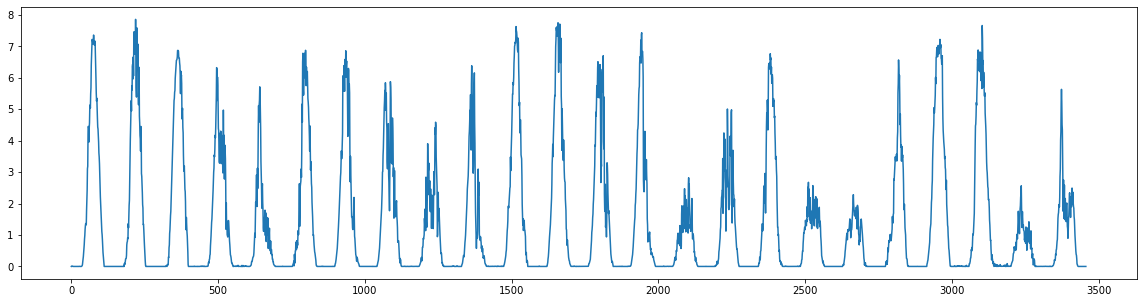

In [14]:
# 그래프 그려 확인해보기
강릉 = pd.read_csv('./pred_stack_region/강릉.csv')

# 현재 모델 돌린 것의 plot

plt.figure(figsize=(20,5))
plt.plot(강릉['UV'])